In [1]:
cd '/mmfs1/data/aglinska/BC-MRI-AE/Colab Notebooks/'

/mmfs1/data/aglinska/BC-MRI-AE/Colab Notebooks


In [2]:
import pickle

import numpy as np
import pandas as pd 

from importlib import reload

import helper_funcs;reload(helper_funcs);from helper_funcs import *
import make_models;reload(make_models);from make_models import *

from functools import partial
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt

### LOAD DATA

In [3]:
dataFnOut = '/mmfs1/data/aglinska/BC-MRI-AE/Data/ABIDE-Anat-64iso-S982.npz'
dfFnOut = '/mmfs1/data/aglinska/BC-MRI-AE/Data/ABIDE_legend_S982.csv'

In [4]:
ABIDE_data = np.load(dataFnOut)['data']
df = pd.read_csv(dfFnOut)

In [5]:
patients = df['DxGroup'].values==1
controls = df['DxGroup'].values==2

In [6]:
arr = np.load('../Data/SFARI-Anat-64iso-S121.npz')
dfs = pd.read_csv('../Data/sfari_legend_S121.csv')

SFARI_data = arr['data']
SFARI_subs = arr['subs']

sfari_subs_td = dfs['family_type'].values=='non-familial-control'
sfari_subs_dupl = dfs['family_type'].values=='16p-duplication'
sfari_subs_del = dfs['family_type'].values=='16p-deletion'

### LOAD NETWORK WEIGHTS

In [7]:
# LOAD VAE
latent_dim=32;batch_size=64;disentangle=False;gamma=1
encoder, decoder, vae = get_MRI_VAE_3D(input_shape=(64, 64, 64, 1), latent_dim=latent_dim, batch_size=batch_size, disentangle=disentangle, gamma=gamma)
#fn = '/mmfs1/data/aglinska/tf_outputs/VAE/Jan12th_16d'
#fn = '/mmfs1/data/aglinska/tf_outputs/VAE/Feb_26_32DB64G1'
fn = '/mmfs1/data/aglinska/tf_outputs/VAE/Feb_26_32DB64G100_DisTrue'


loss = list()
print('ready')
if os.path.exists(fn+'_loss.pickle'):
    print('loading')
    vae.load_weights(fn)
    loss = pickle.load(open(fn+'_loss.pickle','rb'))

ready
loading

Two checkpoint references resolved to different objects (<tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x1554540517f0> and <tensorflow.python.keras.layers.core.Lambda object at 0x1554541452e0>).


In [8]:
# LOAD CVAE
latent_dim = 16;batch_size = 32;beta = 1;gamma = 100;disentangle = True
cvae, z_encoder, s_encoder, cvae_decoder = get_MRI_CCVAE_3D(latent_dim=latent_dim,beta=beta, disentangle=disentangle, gamma=gamma, bias=True, batch_size = batch_size)
loss = list()    

fdir = '/mmfs1/data/aglinska/tf_outputs/CVAE/'
#fn = f'{now().strftime("%b%d_%H%M")}_D{latent_dim}B{beta}G{gamma}_D{disentangle}'
fn = 'Feb04_0524_D16B1G100_DTrue'

#fn = os.path.join(fdir,fn)
fn = '/mmfs1/data/aglinska/tf_outputs/CVAE/Feb23_1551_D16B1G100_DTrue'
#fn = '/mmfs1/data/aglinska/tf_outputs/CVAE/Feb26_1330_CVAE_D16B1G1_adam'

loss = pickle.load(open(fn+'_loss.pickle','rb'))
cvae.load_weights(fn)

### CHECK NETWORKS

In [9]:
sfari_td_batch = SFARI_data[sfari_subs_td,:,:,:][0:15,:,:,:]
sfari_dupl_batch = SFARI_data[sfari_subs_dupl,:,:,:][0:15,:,:,:]
sfari_del_batch = SFARI_data[sfari_subs_del,:,:,:][0:15,:,:,:]

asd_idx,td_idx = get_batch_idx(df,batch_size = batch_size)
DX_batch = np.take(ABIDE_data, indices=asd_idx, axis=0)
TD_batch = np.take(ABIDE_data, indices=td_idx, axis=0)

In [10]:
def cvae_predict(im_in,idx=1):
    # 0 for ASD, 1 for TD
    #im_in = [DX_batch,TD_batch][idx]
    _zeros = np.zeros(s_encoder(im_in)[2].shape)

    v = 2
    cvae_sal_vec = np.hstack((_zeros,s_encoder(im_in)[v]))
    cvae_bg_vec = np.hstack((z_encoder(im_in)[v],_zeros))

    if idx==1:
        cvae_full_vec = np.hstack((z_encoder(im_in)[v],s_encoder(im_in)[v]))
    elif idx==0:
        cvae_full_vec = cvae_bg_vec
        
    out = cvae_decoder.predict(cvae_full_vec)
    
    return out[:,:,:,:,0]

Text(0, 0.5, 'MSE')

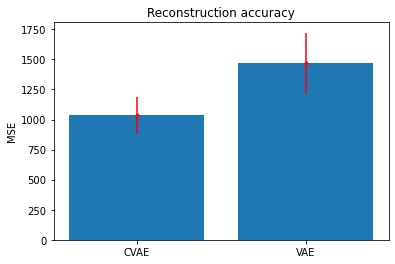

In [11]:
asd_idx,td_idx = get_batch_idx(df,batch_size = batch_size)
DX_batch = np.take(ABIDE_data, indices=asd_idx, axis=0)

matIn = DX_batch
n = matIn.shape[0]

vae_out = decoder.predict(encoder.predict(matIn)[2])[:,:,:,:,0]
cvae_out = cvae_predict(matIn,idx=1)

vae_resid = (matIn-vae_out)**2
cvae_resid = (matIn-cvae_out)**2

vae_acc = np.array([vae_resid[i,:,:,:].sum() for i in range(n)])
cvae_acc = np.array([cvae_resid[i,:,:,:].sum() for i in range(n)])

xs = [0,1];
m = [cvae_acc.mean(),vae_acc.mean()];
se = [cvae_acc.std(),vae_acc.std()];
plt.bar(xs,m);
plt.errorbar(xs,m,se,fmt='r.');
plt.xticks(xs,labels=['CVAE','VAE']);
plt.title('Reconstruction accuracy')
plt.ylabel('MSE')

### ^VAE is a bit worse at reconstruction overall. This needs to be fixed. For these analyses here it doesnt matter much because the reconstructions are still fairly ok. And also - we're mostly interested in the difference between BG and SL space

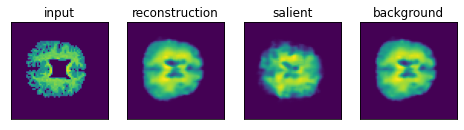

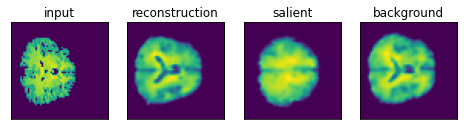

In [12]:
plot_four(DX_batch, TD_batch, z_encoder, s_encoder,cvae_decoder,cvae,idx=0) # PLOT ASD SUBJECT
plot_four(DX_batch, TD_batch, z_encoder, s_encoder,cvae_decoder,cvae,idx=1) # PLOT TD SUBJECT

### CVAE Reconstructions look good

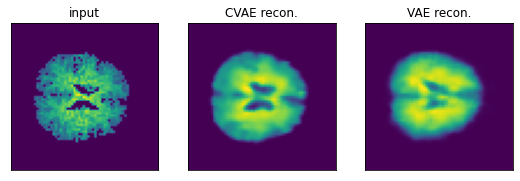

In [13]:
s = 1
plt.figure(figsize=(9,3))
plt.subplot(1,3,1);plt.imshow(matIn[s,:,:,40]);plt.title('input');plt.xticks([]);plt.yticks([]);
plt.subplot(1,3,2);plt.imshow(cvae_out[s,:,:,40]);plt.title('CVAE recon.');plt.xticks([]);plt.yticks([]);
plt.subplot(1,3,3);plt.imshow(vae_out[s,:,:,40]);plt.title('VAE recon.');plt.xticks([]);plt.yticks([]);

### For CVAE and VAE reconstruct the brain images well

In [14]:
w = 0
vae_space = dim_reduce(encoder.predict(ABIDE_data)[w])
bg_space,sl_space = get_spaces(ABIDE_data, z_encoder, s_encoder, w=w, method='UMAP')

### Distributions of ASD subjects in the three spaces. Evidence of clustering in BG, SL and VAE seem random (RSA results will show how they are organized)

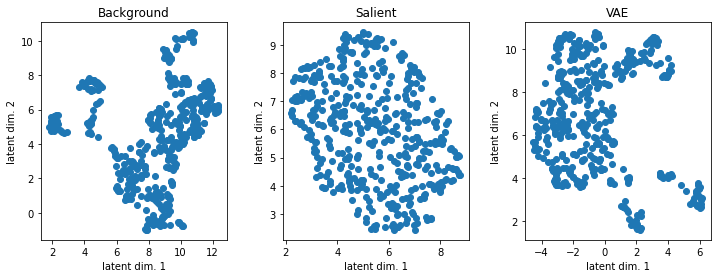

In [15]:
cscatter([bg_space,sl_space,vae_space],v=patients)

In [16]:
%%time
v = patients
rdm_bg = 1-make_RDM(bg_space[v,:],data_scale='ratio')
rdm_sl = 1-make_RDM(sl_space[v,:],data_scale='ratio')
rdm_vae = 1-make_RDM(encoder.predict(ABIDE_data)[2][v,:],data_scale='ratio')

CPU times: user 26.9 s, sys: 2.93 s, total: 29.9 s
Wall time: 1.5 s


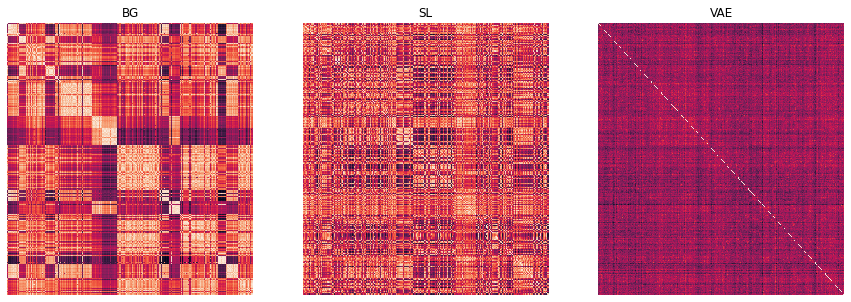

In [17]:
f, ax = plt.subplots(1,3,figsize=(15,5))
sns.heatmap(rdm_bg,cbar=[],ax=ax[0],xticklabels=[],yticklabels=[]);
sns.heatmap(rdm_sl,cbar=[],ax=ax[1],xticklabels=[],yticklabels=[]);
sns.heatmap(rdm_vae,cbar=[],ax=ax[2],xticklabels=[],yticklabels=[]);

[ax[i].set_title(['BG','SL','VAE'][i]) for i in range(3)];

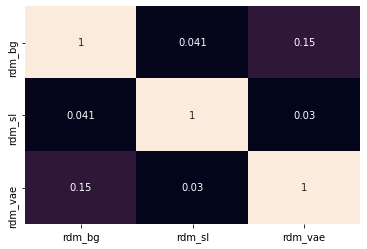

In [18]:
space_cmat = np.corrcoef(np.array([get_triu(x) for x in [rdm_bg,rdm_sl,rdm_vae]]));
lbls= ['rdm_bg','rdm_sl','rdm_vae'];
sns.heatmap(space_cmat,annot=True,cbar=[],xticklabels=lbls,yticklabels=lbls);

### RSA spaces for BG, SL and VAE look ok -  and they are not correlated

# RSA Analyses

RSA analyses of common variables in ASD subjects. 


ADOS, diagnosis (autism, aspergers, PDD-NOS) and FIQ are explained by salient space


Gender, scanner, scansite & age are pulled into background space

nice!

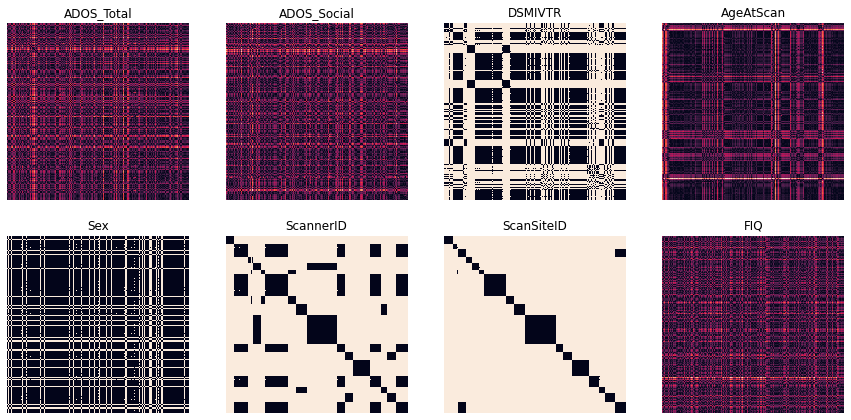

In [160]:

plt.figure(figsize=(15,15))
default_keys = ['ADOS_Total','ADOS_Social','DSMIVTR','AgeAtScan','Sex','ScannerID','ScanSiteID','FIQ']
scales_ = ['ratio','ratio','ordinal','ratio','ordinal','ordinal','ordinal','ratio','ratio','ratio']

for i in range(8):
    plt.subplot(4,4,i+1);
    inVec = df[default_keys[i]].values[patients];
    inVec = inVec[~np.isnan(inVec)];
    sns.heatmap(make_RDM(inVec,data_scale=scales_[i]),cbar=[],xticklabels=[],yticklabels=[]);
    plt.title(default_keys[i]);

CPU times: user 2min 32s, sys: 1min 30s, total: 4min 3s
Wall time: 2min 9s


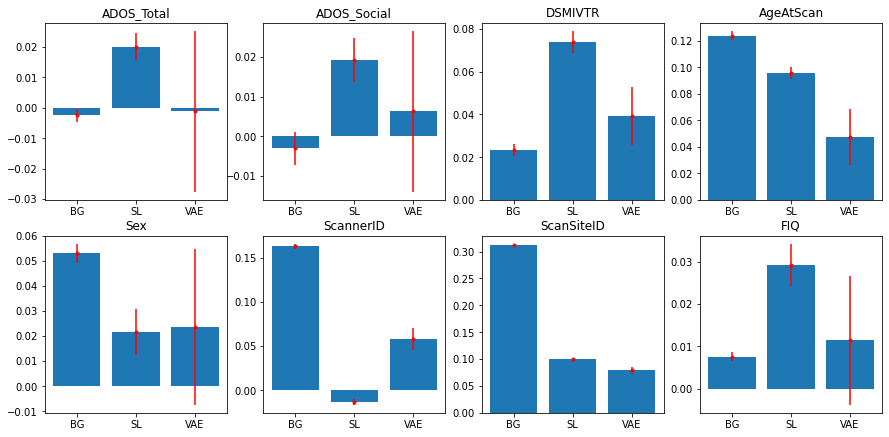

In [19]:
%%time
default_keys = ['ADOS_Total','ADOS_Social','DSMIVTR','AgeAtScan','Sex','ScannerID','ScanSiteID','FIQ']
scales_ = ['ratio','ratio','ordinal','ratio','ordinal','ordinal','ordinal','ratio','ratio','ratio']
plt.figure(figsize=(15,15))

for i in range(len(default_keys)):
    ax = plt.subplot(4,4,i+1)
    rsa_results = [fit_rsa(df[default_keys[i]].values,ABIDE_data,patients,[z_encoder,s_encoder,encoder],data_scale=scales_[i]) for _ in range(10)]
    rsa_results = np.array(rsa_results)
    plot_rsa_results(rsa_results,ax=ax,title=default_keys[i])

Sanity check: common variables for TD subjects. Mostly represented in the background space.

CPU times: user 1min 50s, sys: 1min 3s, total: 2min 54s
Wall time: 1min 33s


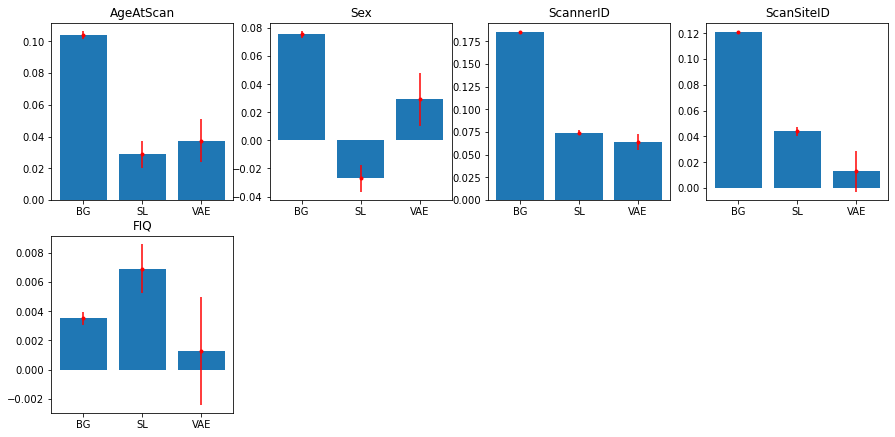

In [20]:
%%time
default_keys = ['AgeAtScan','Sex','ScannerID','ScanSiteID','FIQ']
scales_ = ['ratio','ratio','ordinal','ratio','ordinal','ordinal','ordinal','ratio','ratio','ratio']
plt.figure(figsize=(15,15))

for i in range(len(default_keys)):
    ax = plt.subplot(4,4,i+1)
    rsa_results = [fit_rsa(df[default_keys[i]].values,ABIDE_data,controls,[z_encoder,s_encoder,encoder],data_scale=scales_[i]) for _ in range(10)]
    rsa_results = np.array(rsa_results)
    plot_rsa_results(rsa_results,ax=ax,title=default_keys[i])

There are different ADOS and ADI measurements (see keys below). They index social impairements, communication aspects etc.

ADOS is a questionaire administer to the child and indexes current behaviors. 

ADI is a questionaire (interview) administered to the parents and indexes both current and longer scale patterns of behavior. 

First - let's take the PCA of the ADOS and ADI scores and compute RDM based on PCs (similarity in component loading) and compare that RSA to background, salient and VAE spaces.

I compute three PCs and plot one the ones that explain 25% or more variance. In the scores below, first PC explains 48% of variance, 2nd explains 32% and 3rd explains 7% so only the first two PCs are anlyzed. 

204 subjects
[0.47578144 0.3273248  0.08279598]
CPU times: user 9min 5s, sys: 45.4 s, total: 9min 50s
Wall time: 32.4 s


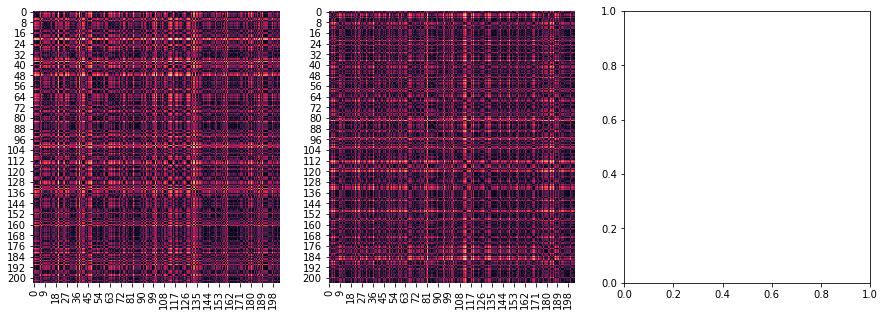

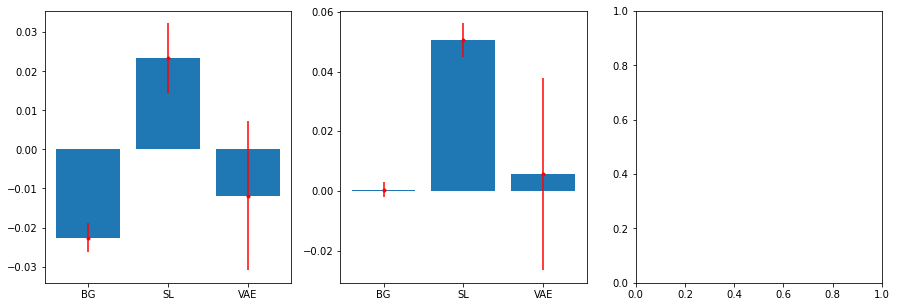

In [20]:
%%time
keys = ['ADOS_Total','ADOS_Social','ADI_R_SocialTotal','ADI_R_VerbalTotal','ADI_R_RRB','ADI_R_Onset Total','ADOS_Comm','ADOS_Social','ADOS_StBeh']
pca_ados_res_asd = plot_pca_rsa(keys,df,ABIDE_data,patients,[z_encoder,s_encoder,encoder])

### Seems like the salient space is sensitive to differences in ADOS scores (across both PCs). The negative values for BG in 1st PC analyses are hard to interpret (ASD subjects that are different in ADOS RDM are similar in BG rdm)

And here are the model fits for individual ADOS and ADI measurements. These would probably go in the appendix

CPU times: user 3min 10s, sys: 1min 47s, total: 4min 57s
Wall time: 2min 38s


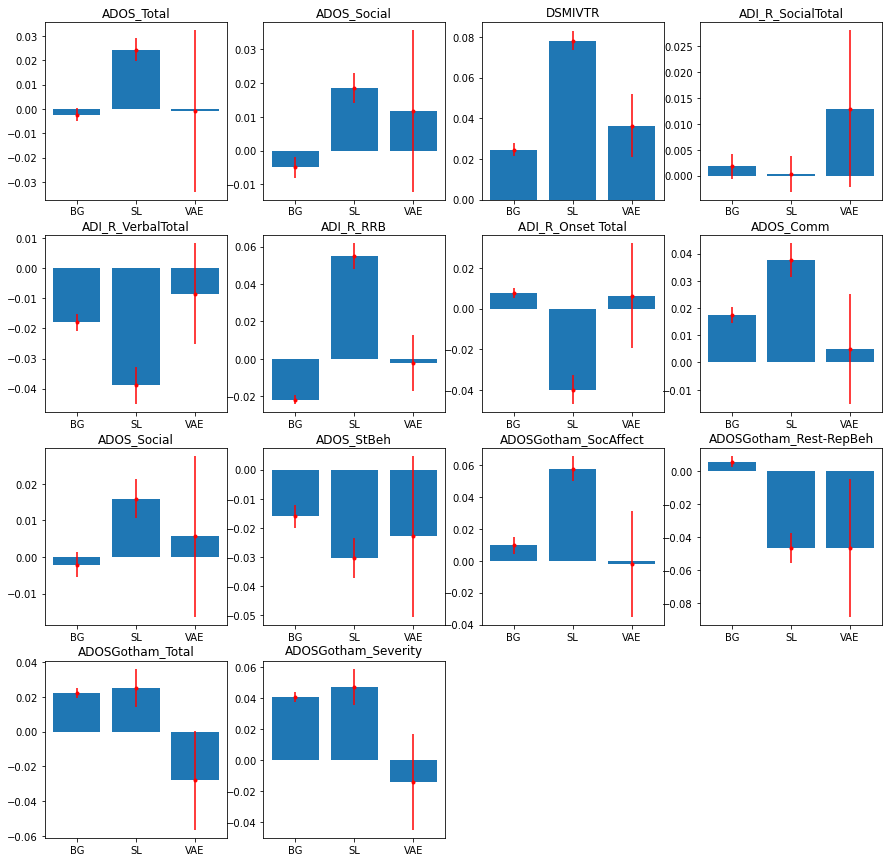

In [22]:
%%time
default_keys = ['ADOS_Total','ADOS_Social','DSMIVTR','ADI_R_SocialTotal','ADI_R_VerbalTotal','ADI_R_RRB','ADI_R_Onset Total','ADOS_Comm','ADOS_Social','ADOS_StBeh','ADOSGotham_SocAffect', 'ADOSGotham_Rest-RepBeh',
       'ADOSGotham_Total', 'ADOSGotham_Severity']

scales_ = ['ratio','ratio','ordinal','ratio','ratio','ratio','ratio','ratio',None,None,None,None,None,None,None,None,None,None,None,None,None,None]
plt.figure(figsize=(15,15))
#[plt.subplot(4,4,i+1) for i in range(8)];

for i in range(len(default_keys)):
    ax = plt.subplot(4,4,i+1)
    rsa_results = [fit_rsa(df[default_keys[i]].values,ABIDE_data,patients,[z_encoder,s_encoder,encoder],data_scale=scales_[i]) for _ in range(10)]
    rsa_results = np.array(rsa_results)
    plot_rsa_results(rsa_results,ax=ax,title=default_keys[i])

# VINELAND scores

"The Vineland Adaptive Behavior Scales (VABS) (Vineland-3) is a standardized assessment tool that utilizes semi-structured interview to measure adaptive behavior and support the diagnosis of intellectual and developmental disabilities, autism, and developmental delays. It may be used to determine eligibility or qualification for special services, plan rehabilitation or intervention programs, and track and report progress"


[link about Vineland](https://www.pearsonassessments.com/store/usassessments/en/Store/Professional-Assessments/Behavior/Adaptive/Vineland-Adaptive-Behavior-Scales-%7C-Third-Edition/p/100001622.html)

In [171]:
# There are multiple measures (aspects) of VINELAND scores (see keys below). 

keys = ['VINELAND_Receptive_Vscore',
 'VINELAND_Expressive_Vscore',
 'VINELAND_Written_Vscore',
 'VINELAND_CommunicationStandard',
 'VINELAND_Personal_Vscore',
 'VINELAND_Domestic_Vscore',
 'VINELAND_Community_Vscore',
 'VINELAND_DaylyLiving_Standard',
 'VINELAND_Interpersonal_Vscore',
 'VINELAND_Play_Vscore',
 'VINELAND_Coping_Vscore',
 'VINELAND_Socical_Standard',
 'VINELAND_Domestic_Standard',
 'VINELAND_ABC_Standard',
 'VINELAND_Informant']

First - let's take the PCA of the vineland scores and compute RDM (similarity in component loading) and compare that RSA to background, salient and VAE spaces.

I compute three PCs and plot one the ones that explain 25% or more variance. In the scores below, first PC explains 93% of variance, 2nd explains 2% and 3rd explains 1.7% so only the first PC is anlyzed. 

69 subjects
[0.93657542 0.02026046 0.01758683]


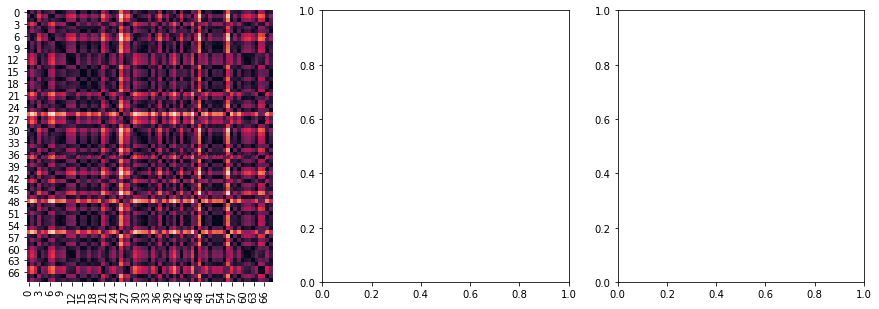

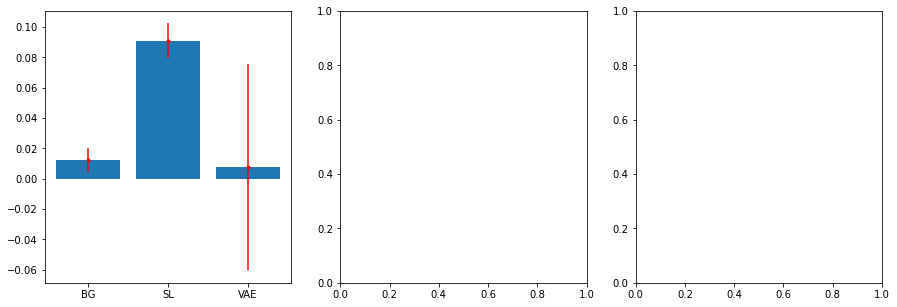

In [172]:
pca_vineland_asd = plot_pca_rsa(keys,df,ABIDE_data,patients,[z_encoder,s_encoder,encoder])

# ASD subjects
# Matrix shows similarity in Vineland scores between participants with ASD
# Bar graphs shows model fit to background, salient and VAE space RDMs
# ASD participants that differ in Vineland scores also differ in the salient space embedding

Vineland scores for TD subjects: no effect in salient space

43 subjects
[0.93657542 0.02026046 0.01758683]


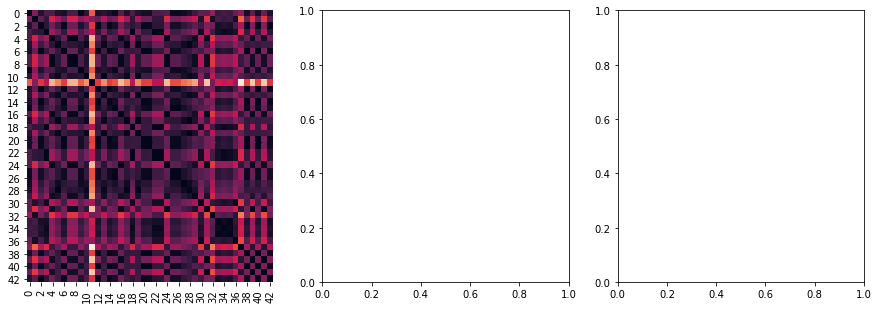

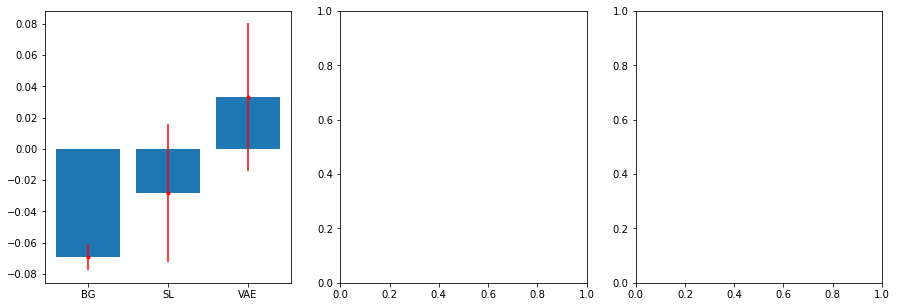

In [173]:
pca_vineland_td = plot_pca_rsa(keys,df,ABIDE_data,controls,[z_encoder,s_encoder,encoder])
# Vineland scores for controls. No effects

### Individual vineland measures fit to data

For visualization - instead of doing PCA let's run model fit for individual scores. This is something for the appendix

CPU times: user 55.2 s, sys: 31.1 s, total: 1min 26s
Wall time: 50.5 s


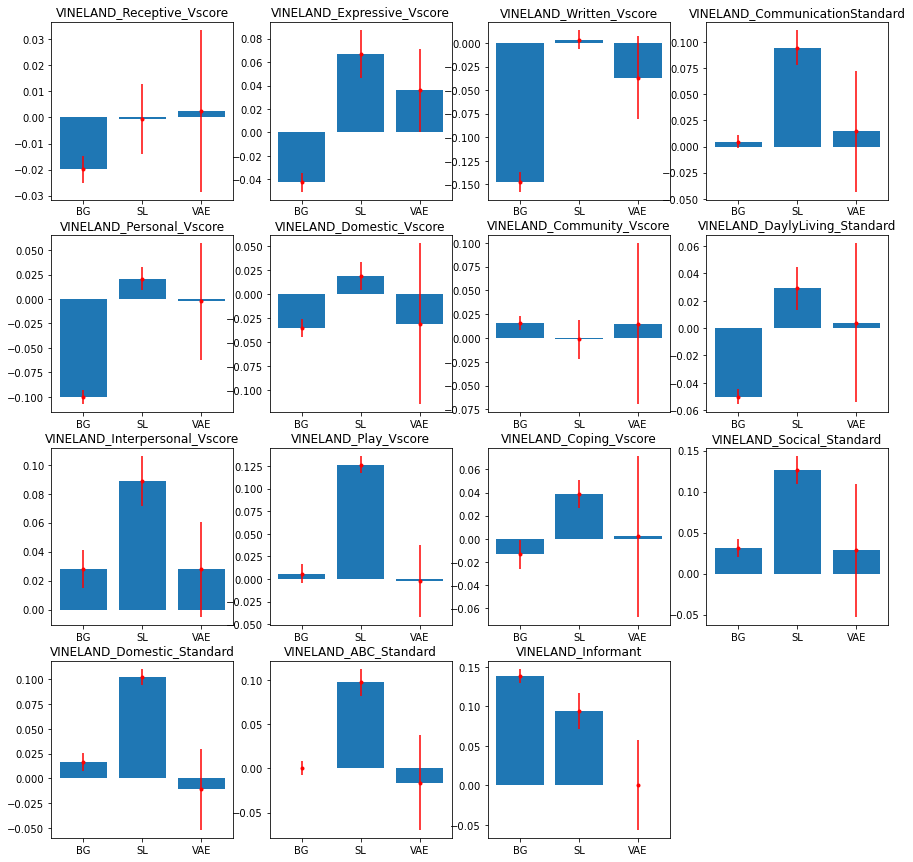

In [26]:
%%time
default_keys = ['VINELAND_Receptive_Vscore',
 'VINELAND_Expressive_Vscore',
 'VINELAND_Written_Vscore',
 'VINELAND_CommunicationStandard',
 'VINELAND_Personal_Vscore',
 'VINELAND_Domestic_Vscore',
 'VINELAND_Community_Vscore',
 'VINELAND_DaylyLiving_Standard',
 'VINELAND_Interpersonal_Vscore',
 'VINELAND_Play_Vscore',
 'VINELAND_Coping_Vscore',
 'VINELAND_Socical_Standard',
 'VINELAND_Domestic_Standard',
 'VINELAND_ABC_Standard',
 'VINELAND_Informant']

scales_ = [None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None]
plt.figure(figsize=(15,15))
#[plt.subplot(4,4,i+1) for i in range(8)];

for i in range(len(default_keys)):
    ax = plt.subplot(4,4,i+1)
    rsa_results = [fit_rsa(df[default_keys[i]].values,ABIDE_data,patients,[z_encoder,s_encoder,encoder],data_scale=scales_[i]) for _ in range(10)]
    rsa_results = np.array(rsa_results)
    plot_rsa_results(rsa_results,ax=ax,title=default_keys[i])

### WISC4 is the Wechsler Intelligence Scale for Children: only PCA results (for computational convenience)

22 subjects
[0.59941329 0.15772874 0.13149017]
CPU times: user 30.3 s, sys: 2.45 s, total: 32.8 s
Wall time: 2.47 s


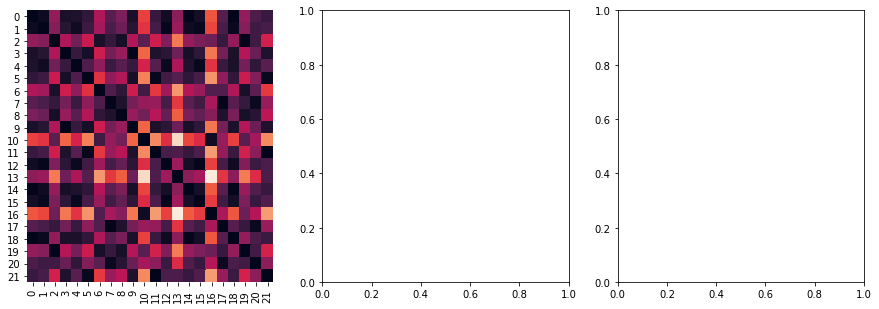

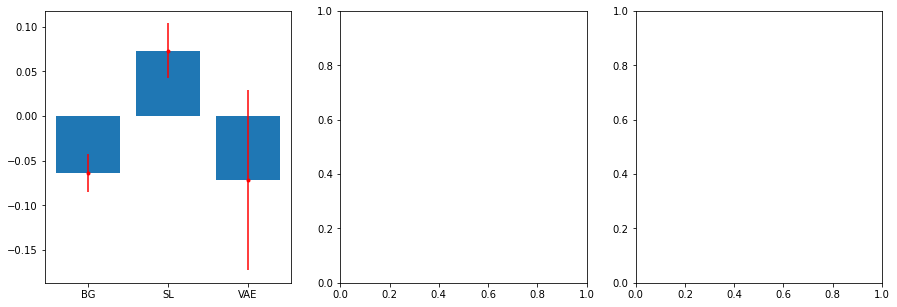

In [126]:
%%time
keys = ['WISC4 VCI Verbal Comprehension Index',
       'WISC4 PRI Perceptual Reasoning Index',
       'WISC4 WMI Working Memory Index', 'WISC4 PSI Processing Speed Index',
       'WISC4 Sim Scaled', 'WISC4 Vocab Scaled', 'WISC4 Info Scaled',
       'WISC4 Blk Dsn Scaled', 'WISC4 Pic Con Scaled', 'WISC4 Matrix Scaled',
       'WISC4 Dig Span Scaled', 'WISC4 Let Num Scaled', 'WISC4 Coding Scaled',
       'WISC4 Sym Scaled']

wisc_res_ASD = plot_pca_rsa(keys,df,ABIDE_data,patients,[z_encoder,s_encoder,encoder])

Overall - background space is sensitive to differences in common confounds and salient space is sensitive to ADOS and IQ scores of patients

33 subjects
[0.59941329 0.15772874 0.13149017]
CPU times: user 45.6 s, sys: 3.84 s, total: 49.5 s
Wall time: 4.12 s


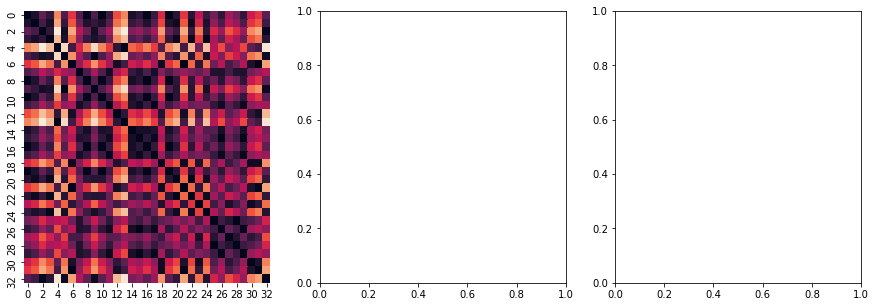

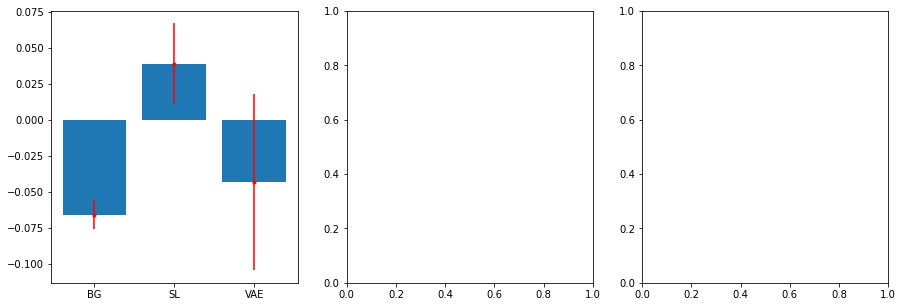

In [22]:
%%time 
keys = ['WISC4 VCI Verbal Comprehension Index',
       'WISC4 PRI Perceptual Reasoning Index',
       'WISC4 WMI Working Memory Index', 'WISC4 PSI Processing Speed Index',
       'WISC4 Sim Scaled', 'WISC4 Vocab Scaled', 'WISC4 Info Scaled',
       'WISC4 Blk Dsn Scaled', 'WISC4 Pic Con Scaled', 'WISC4 Matrix Scaled',
       'WISC4 Dig Span Scaled', 'WISC4 Let Num Scaled', 'WISC4 Coding Scaled',
       'WISC4 Sym Scaled']

wisc_res_TD = plot_pca_rsa(keys,df,ABIDE_data,controls,[z_encoder,s_encoder,encoder])

In [174]:
PCA(n_components=1).fit_transform

<bound method PCA.fit_transform of PCA(n_components=1)>

In [175]:
from plotnine import *
from plotnine import geoms

In [176]:
#mat = np.array([wisc_res_TD[0],wisc_res_ASD[0]])
mat = np.array([pca_vineland_td[0],pca_vineland_asd[0]])
mat = np.swapaxes(mat,0,1)
mat.shape

(10, 2, 3)

In [177]:
columns = ['fit','group','enc']
lbls = [['TD','ASD'],['bg','sl','vae']]

In [178]:
l = np.zeros(mat.shape)
l = np.array(l, dtype='object')
l[:,0,:] = 'TD'
l[:,1,:] = 'ASD'
g = l.flatten()

In [179]:
l = np.zeros(mat.shape)
l = np.array(l, dtype='object')
l[:,:,0] = 'bg'
l[:,:,1] = 'sl'
l[:,:,2] = 'vae'
e = l.flatten()

In [180]:
myDF = pd.DataFrame(columns=columns)
myDF['fit'] = mat.flatten()
myDF['group'] = g.flatten()
myDF['enc'] = e.flatten()

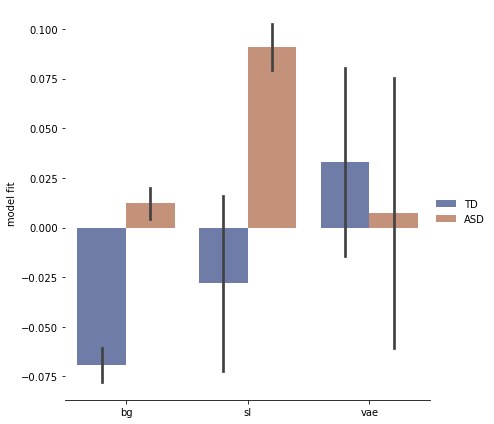

In [181]:
# Draw a nested barplot by species and sex
#plot_df = fit_df[fit_df["enc"].isin(['sl','bg'])]
plot_df = myDF

g = sns.catplot(
    data=plot_df, kind="bar",
    x="enc", y="fit", hue="group",
    ci="sd", palette="dark", alpha=.6, height=6
)

g.despine(left=True)
g.set_axis_labels("", "model fit")
g.legend.set_title("")

In [186]:
i = 2
inVec = dfs[default_keys[i]].values[(sfari_subs_del+sfari_subs_dupl)];
inVec = inVec[~np.isnan(inVec)];


array([ 2.,  3.,  7.,  2.,  1.,  4.,  3.,  1.,  4.,  2.,  1.,  5.,  2.,
        1.,  3.,  2.,  3.,  2.,  3.,  7.,  1.,  3.,  2.,  4.,  1.,  2.,
        2.,  7.,  2.,  3.,  7.,  1.,  1.,  3.,  1.,  9., 10.,  2.,  1.,
        2.,  2.,  1.,  3.,  6.,  2.,  7.,  6.,  3.,  4.,  1.,  1.])

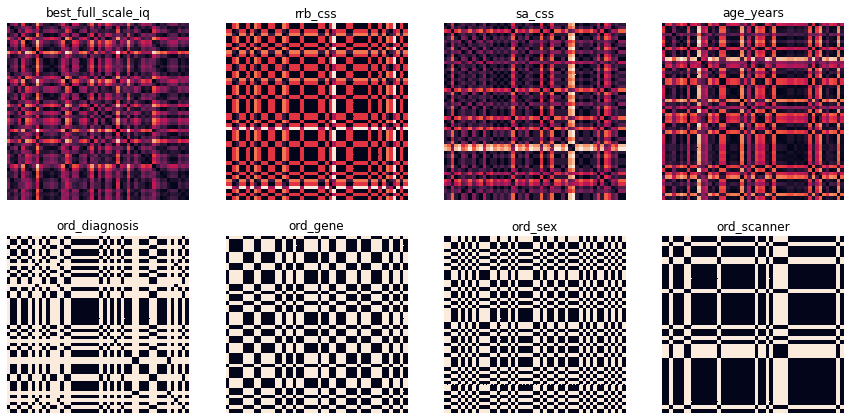

In [184]:
plt.figure(figsize=(15,15))

default_keys = ['best_full_scale_iq','rrb_css','sa_css','age_years', 'ord_diagnosis',
       'ord_gene', 'ord_sex','ord_scanner']
scales_ = [None,None,None,None,'ordinal','ordinal','ordinal','ordinal']

for i in range(8):
    plt.subplot(4,4,i+1);
    inVec = dfs[default_keys[i]].values[(sfari_subs_del+sfari_subs_dupl)];
    inVec = inVec[~np.isnan(inVec)];
    sns.heatmap(make_RDM(inVec,data_scale=scales_[i]),cbar=[],xticklabels=[],yticklabels=[]);
    plt.title(default_keys[i]);

CPU times: user 27.7 s, sys: 9 s, total: 36.7 s
Wall time: 22.3 s


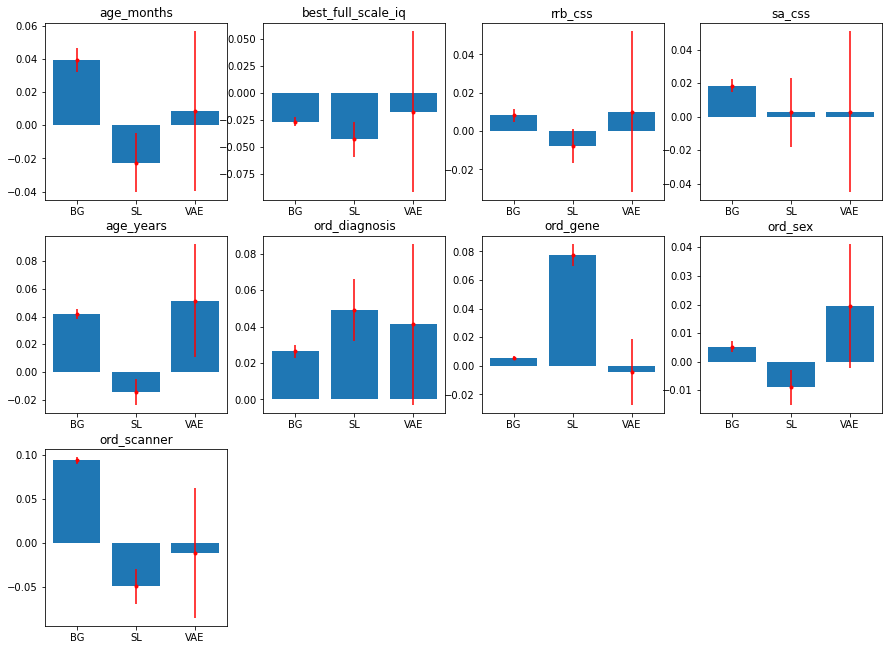

In [31]:
%%time 
plt.figure(figsize=(15,15))

default_keys = ['age_months','best_full_scale_iq','rrb_css','sa_css','age_years', 'ord_diagnosis',
       'ord_gene', 'ord_sex','ord_scanner']

scales_ = [None,None,None,None,None,'ordinal','ordinal','ordinal','ordinal']

for i in range(len(default_keys)):
    ax = plt.subplot(4,4,i+1)
    rsa_results = [fit_rsa(dfs[default_keys[i]].values,SFARI_data,(sfari_subs_del+sfari_subs_dupl),[z_encoder,s_encoder,encoder],data_scale=scales_[i]) for _ in range(10)]
    rsa_results = np.array(rsa_results)
    plot_rsa_results(rsa_results,ax=ax,title=default_keys[i])

In [32]:
from scipy import stats
ttest_rel = stats.ttest_rel

In [33]:
import scipy
s_embed = s_encoder.predict(ABIDE_data[patients,:,:,:])[0]
z_embed = z_encoder.predict(ABIDE_data[patients,:,:,:])[0]
v_embed = encoder.predict(ABIDE_data[patients,:,:,:])[0]

CPU times: user 95.7 ms, sys: 72.4 ms, total: 168 ms
Wall time: 82.1 ms


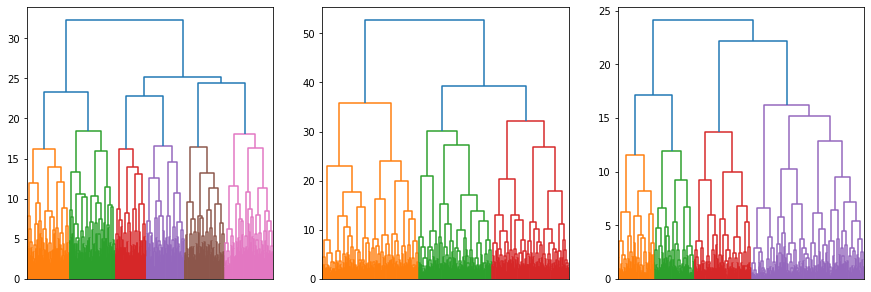

In [34]:
%%time
plt.figure(figsize=(15,5))
for i in range(3):
    plt.subplot(1,3,i+1)
    y = [s_embed,z_embed,v_embed][i];
    Z = scipy.cluster.hierarchy.linkage(y,method='ward',metric='euclidean',optimal_ordering=False);
    d = scipy.cluster.hierarchy.dendrogram(Z,p=30,truncate_mode=None,color_threshold=None,get_leaves=True,orientation='top',labels=None,count_sort=False,distance_sort=False,show_leaf_counts=True,no_plot=False,no_labels=True,leaf_font_size=None,leaf_rotation=None,leaf_label_func=None,show_contracted=False,link_color_func=None,ax=None,above_threshold_color='C0');

In [35]:
import sklearn.cluster
km = sklearn.cluster.KMeans

CPU times: user 6min, sys: 14min 57s, total: 20min 58s
Wall time: 1min 1s


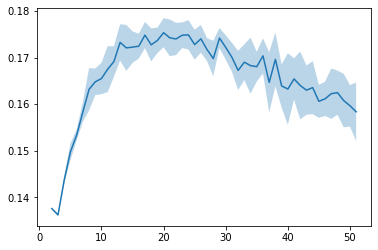

In [36]:
%%time
n = 50
nrep = 10
sil = np.zeros((n,nrep))
emb = z_encoder.predict(ABIDE_data[patients,:,:,:])[0]
for j in range(nrep):
    for i in range(n):
        cid = km(n_clusters=i+2).fit_predict(emb)
        sil[i,j] = silhouette_score(emb,cid)

x = np.arange(n)+2
y = sil.mean(axis=1)
e = sil.std(axis=1)
plt.plot(x,y)
plt.fill_between(x,y-e,y+e,alpha=.3)